<a href="https://colab.research.google.com/github/MarigoldJ/ygl2/blob/main/class/20210625_nlp_day9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BILSTM + CRF 개체명 인식

[참고링크 - 위키독스](https://wikidocs.net/34156)

In [ ]:
# ! pip install tensorflow==1.14.0
! pip install keras==2.2.4
# ! pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 317kB 8.4MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-rnclefo9
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-rnclefo9
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=0c791aef4c94134434c4280c61cfae4c6e7660a07f74dd95181bfaf97f500f50
  Stored in directory: /tmp/pip-ephem-wheel-cache-ln0ztm_c/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
! wget -NP ./ https://raw.githubusercontent.com/MarigoldJ/ygl2/main/%ED%95%99%EC%8A%B5%EC%9E%90%EB%A3%8C/NLP/dataset/ner_dataset.csv

path_to_file_kaggle = './ner_dataset.csv'

--2021-06-25 02:57:38--  https://raw.githubusercontent.com/MarigoldJ/ygl2/main/%ED%95%99%EC%8A%B5%EC%9E%90%EB%A3%8C/NLP/dataset/ner_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14159575 (14M) [text/plain]
Saving to: ‘./ner_dataset.csv’

ner_dataset.csv     100%[===================>]  13.50M  40.5MB/s    in 0.3s    

Last-modified header missing -- time-stamps turned off.
2021-06-25 02:57:39 (40.5 MB/s) - ‘./ner_dataset.csv’ saved [14159575/14159575]



In [ ]:
# 캐글데이터 불러오기
data = pd.read_csv(path_to_file_kaggle, encoding='latin1')
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [ ]:
# 데이터 확인해보기
print('데이터 행 개수 :', len(data))
print('데이터 null값이 있는가? :', data.isnull().values.any())

데이터 행 개수 : 1048575
데이터 null값이 있는가? : True


In [ ]:
print('Sentence # 열의 중복을 제거한 값의 개수 :', data['Sentence #'].nunique())    # 문장 개수
print('Word 열의 중복을 제거한 값의 개수 :', data['Word'].nunique())                # 단어 가짓수
print('Tag 열의 중복을 제거한 값의 개수 :', data['Tag'].nunique())                  # 태그 가짓수

Sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [ ]:
print('Tag 열의 각 값의 개수')
print('='*30)
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각 값의 개수
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [ ]:
# null값 제거
data = data.fillna(method='ffill')  # front fill
data.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
# null 값 제거가 잘 되었는지 확인
print('데이터 null값이 있는가? :', data.isnull().values.any())

데이터 null값이 있는가? : False


In [ ]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 :', data['Word'].nunique())    # 단어 가짓수
print()
data.head()

Word 열의 중복을 제거한 값의 개수 : 31817



,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
func = lambda temp: [(w, t) for w, t in zip(temp['Word'].values.tolist(), temp['Tag'].values.tolist())]
tagged_sentences = [t for t in data.groupby('Sentence #').apply(func)]
print('전체 샘플의 개수 :', len(tagged_sentences))
print()
print(tagged_sentences[0])   # 첫번째 샘플 출력

전체 샘플의 개수 : 47959

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
#
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:        # 샘플마다
    sentence, tag_info = zip(*tagged_sentence)  # 단어->sentence, 개체명 태깅정보->tag_info
    sentences.append(list(sentence))            # 단어정보 리스트에 저장
    ner_tags.append(list(tag_info))             # 태깅정보 리스트에 저장

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863987989741236


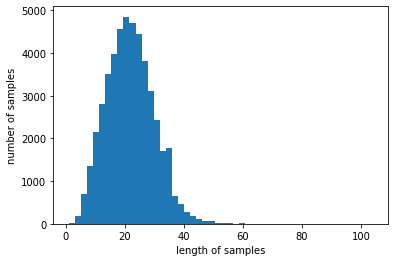

In [ ]:
print('샘플의 최대 길이 :', max(len(l) for l in sentences))             # 샘플문장의 최대 길이
print('샘플의 평균 길이 :', sum(map(len, sentences)) / len(sentences))  # 샘플문장의 평균 길이

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV')      # 모든 단어들을 사용하지만, 인덱스 1에는 단어 'OOV'를 할당함.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False)          # 태깅 정보들은 내부적으로 대문자 유지한채 저장.
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = len(src_tokenizer.index_word) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 :', vocab_size)     # 단어 정보 집합의 크기
print('태그 집합의 크기 :', tag_size)       # 개체명 태깅 정보 집합의 크기

단어 집합의 크기 : 31819
태그 집합의 크기 : 18


In [ ]:
print('단어 OOV의 인덱스 :', src_tokenizer.word_index['OOV'])

단어 OOV의 인덱스 : 1


In [ ]:
x_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

print(sentences[0])     # 문장
print(x_data[0])        # 문장 sesquence
print()
print(ner_tags[0])      # 태그
print(y_data[0])        # 태그 sequence

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'     # 원래 index 0 에 해당하는 태그가 없으므로 추가해줌.

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [ ]:
# 문장 길이 맞추기
max_len = 70
x_data_pad = pad_sequences(x_data, padding='post', maxlen=max_len)
y_data_pad = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
# train, test data 나누기
x_train, x_test, y_train, y_test = train_test_split(x_data_pad, y_data_pad, test_size=.2, random_state=777)

In [ ]:
# target data를 원핫인코딩하기 -> split이전에 이 시행을 해도 될듯
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
# 데이터 shape 확인
print('Train Input  :', x_train.shape)
print('Train Output :', y_train.shape)
print('Test  Input  :', x_test.shape)
print('Test  Output :', y_test.shape)

Train Input  : (38367, 70)
Train Output : (38367, 70, 18)
Test  Input  : (9592, 70)
Test  Output : (9592, 70, 18)


## F1-Score test

In [ ]:
# 실제값
true = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O']

# 예측값
pred = ['O'] * len(true)

print(pred)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
# 정답 개수 세기
hit = 0
for t, p in zip(true, pred):
    if t==p:
        hit += 1

# 정확도(accuracy)
accuracy = hit / len(true)
print(f'정확도 : {100*accuracy:.2f}%')

정확도 : 78.26%


In [ ]:
! pip install seqeval

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=092d128e36d72cddafc2b07dcc1d0d2a303207a52b6008775a6fbdf70d925573
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
# 정밀도(precision), 재현률(recall)
# 정밀도 = TP / (TP + FP) : 특정 개체라고 예측한 경우 중 예측이 일치한 비율
# 재현률 = TP / (TP + FN) : 특정 개체 중 정답을 맞춘 비율
# f1 score = 2 * (정밀도 * 재현률) / (정밀도 + 재현률)

In [ ]:
from seqeval.metrics import classification_report

print(classification_report([true], [pred]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00         3
   macro avg       0.00      0.00      0.00         3
weighted avg       0.00      0.00      0.00         3



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## F1-score를 측정하는 콜백 클래스

In [ ]:
from tensorflow.keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

In [ ]:
class F1score(Callback):
    
    def __init__(self, value=0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char
    
    def sequences_to_tags(self, sequences):
        result = []
        for sequence in sequences:
            tag = []
            for pred in sequence:                       # seq로부터 예측값을 하나씩 꺼냄
                pred_index = np.argmax(pred)            # [0 0 1 0 0]이라면 2를 반환
                tag.append(index_to_ner[pred_index].replace('PAD', 'O'))
            result.append(tag)
        return result

    def on_epoch_end(self, epoch, logs={}):
        '''
        에포크 끝날 때 마다 실행되는 함수
        '''
        # char Embedding 사용하는 경우
        if self.use_char:
            x_test = self.validation_data[0]
            x_char_test = self.validation_data[1]
            y_test = self.validation_data[2]
            y_predicted = self.model.predict([x_test, x_char_test])
        else:
            x_test = self.validation_data[0]
            y_test = self.validation_data[1]
            y_predicted = self.model.predict([x_test])
        
        pred_tags = self.sequences_to_tags(y_predicted)
        test_tags = self.sequences_to_tags(y_test)

        score = f1_score(pred_tags, test_tags)

        print(f' - f1: {100*score:04.2f}')
        print(classification_report(test_tags, pred_tags))

        # F1 score가 지금까지 중 가장 높은 경우
        if score > self.values:
            print(f'f1_score improved from {self.value} to {score}, saving model to best_model.h5')
            self.model.save('best_model.h5')
            self.value = score
        else:
            print(f'f1_score did not impove from {self.value}')


## 제목 미정 (여긴 망했어요)

1. 문장의 첫번째 단어에는 I가 나오지 않습니다.
2. O-I 패턴은 나오지 않는다.
3. B-I-I 패턴에서 개체명은 일관성을 유지합니다.
    * ex : B-PER 다음에는 I-PER과 I-Org중 I-PER이 오는것이 맞다.

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

AttributeError: ignored

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

Using TensorFlow backend.


AttributeError: ignored

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)

AttributeError: ignored

In [ ]:
import keras
keras.__version__

AttributeError: ignored

In [ ]:
import keras
keras.__version__

'2.5.0'

# Transformer

## 기존의 seq2seq모델의 한계


* 입력시퀀스를 하나의 벡터표현으로 압축(context vector)
    * 디코더는 이를 통해 출력 시퀀스를 만들어냄
* 정보가 일부 손실된다는 단점

* $d_{model} = 512$
* num_layers = 6
* num_heads = 8
* $d_{ff} = 2048$

![](https://wikidocs.net/images/page/31379/transformer1.PNG)
![](https://wikidocs.net/images/page/31379/transformer2.PNG)
![](https://wikidocs.net/images/page/31379/transformer4_final_final_final.PNG)

## 포지셔널 인코딩

![](https://wikidocs.net/images/page/31379/transformer5_final_final.PNG)

![](https://wikidocs.net/images/page/31379/transformer6_final.PNG)

![](https://wikidocs.net/images/page/31379/transformer7.PNG)

- pos : 입력 문장에서의 임베딩 벡터의 위치 
- i : 임베딩 벡터 내의 차원의 인덱스를 의미  
(pos, 2i) -->사인함수, (pos, 2i+1) --> 코사인함수

## 코드실습

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [36]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


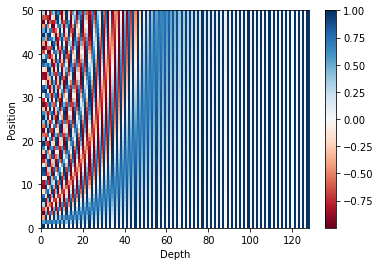

In [37]:
# 50x 128크기를 가지는 포지셔널인코딩 행렬을 시각화해서 어떤 형태를 가지는지 봅시다.
# 입력 문장의 단어가 50, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel('Depth')
plt.xlim((0,128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 어텐션

![](https://wikidocs.net/images/page/31379/attention.PNG)

- 인코더 셀프 어텐션 : Query = Key = value
- 디코더 마스크드 셀프 어텐션 : Query = Key = value
- 디코더의 인코더-디코더 어텐션 : Query (디코더 벡터)  
key = value (인코더 벡터)

![](https://wikidocs.net/images/page/31379/transformer_attention_overview.PNG)

## 인코더

![](https://wikidocs.net/images/page/31379/transformer9_final_ver.PNG)

## 셀프 어텐션

![](https://wikidocs.net/images/page/22893/%EC%BF%BC%EB%A6%AC.PNG)

* Query(쿼리)에 대해서 모든 키(Key)의 유사도

* seq2seq에서 Q,K,V
    - Query : t시점의 디코더 셀에서의 은닉상태
    - Key : 모든 시점의 인코더 셀의 은닉상태
    - values : 모든 시점의 인코더 셀의 은닉상태

* transformer에서 Q, K, V
    - Query : 입력 문장의 모든 단어 벡터들
    - Key : 입력 문장의 모든 단어 벡터들
    - Value : 입력 문장의 모든 단어 벡터들

![](https://wikidocs.net/images/page/31379/transformer10.png)

### Q, K, V 벡터 얻기

![](https://wikidocs.net/images/page/31379/transformer11.PNG)

- $d_{model}$ = 512
- $num_{heads}$ = 8
- 512/8 = 64

### 스케일드 닷 프로덕트 어텐션

![](https://wikidocs.net/images/page/31379/transformer13.PNG)

![](https://wikidocs.net/images/page/31379/transformer14_final.PNG)

In [11]:
# 구현

def scaled_dot_product_attention(query, key, value, mask):
    '''
    query size : (batch_size, num_heads, query_len, d_model/num_heads)
    key size : (batch_size, num_heads, key_len, d_model/num_heads)
    value size : (batch_size, num_heads, value_len, d_model/num_heads)
    
    padding mask : (batch_size, 1, 1, key_len)
    '''

    # Q와 K의 곱
    matmul_qk = tf.matmul(query, key, transpose_b = True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weight = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이 , d_model/num_heads)
    output = tf.matmul(attention_weight, value)

    return output, attention_weight

In [12]:
# scaled_dot_product_attention 함수가 정상적으로 작동하는지 테스트!
import numpy as np
import tensorflow as tf

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)    # (4,3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)     # (4,2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)    # (1,3)

In [13]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)        # 어텐션 분포 (어텐션 가중치)
print(temp_out)         # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [14]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)    # (4,3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)     # (4,2)

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)    # (1,3)

# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)        # 어텐션 분포 (어텐션 가중치)
print(temp_out)         # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 멀티 헤드 어텐션

* 병렬 어텐션의 효과
    * 머리가 여러개, 따라서 여러 시점에서 상대방을 볼 수 있다.
    

1. $W_Q$, $W_K$, $W_V$에 해당하는 $d_{model}$ 크기의 밀집층(Dense Layer)을 지남
2. 지정된 헤드 수(num_heads)만큼 나눔.
3. 스케일드 닷 프로덕트 어텐션
4. 나눠졌던 헤드들을 연결한다.
5. $W_O$에 해당하는 밀집층을 지나게 된다.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값
        # 논문 기준 64
        self.depth = d_model // self.num_heads

        # W_Q, W_K, W_V에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layer.Dense(d_model)
        self.key_dense = tf.keras.layer.Dense(d_model)
        self.value_dense = tf.keras.layer.Dense(d_model)

        # W_Q에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(d_model)

    
    def split_heads(self, inputs, batch_size):
        '''
        num_heads개수만큼 q, k, v를 split하는 함수
        '''
        inputs = tf.reshape(
            inputs, shape = (batch_size, -1, self.num_heads, self.depth)
        )
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. W_Q, W_K, W_K에 해당하는 밀집층 지나기
        # q : (batch_size, query 문장길이, d_model)
        # k : (batch_size, key   문장길이, d_model)
        # v : (batch_size, value 문장길이, d_model)
        # 참고 -> 인코더 (k, v) - 디코더 (q) 어텐션에서는 query길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query 문장길이, d_model/num_heads)
        # k : (batch_size, num_heads, key   문장길이, d_model/num_heads)
        # v : (batch_size, num_heads, value 문장길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션
        # (batch_size, num_heads, query 문장길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query 문장길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결
        # (batch_size, query 문장길이, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 5. W_O에 해당하는 밀집층 지나기
        # (batch_size, query 문장길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

## 패딩 마스크

![](https://wikidocs.net/images/page/31379/pad_masking11.PNG)

![](https://wikidocs.net/images/page/31379/pad_masking2.PNG)

![](https://wikidocs.net/images/page/31379/softmax.PNG)

In [22]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key 문장길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [23]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


## 포지션-와이드 피드 포워드 신경망

$$ FFNN(x) = MAX(0, xW_1 + B_1)W_2 + b_2$$

![](https://wikidocs.net/images/page/31379/positionwiseffnn.PNG)

```
outputs = tf.keras.layers.Dense(dff, activation='relu')(attention)
```

## 잔차 연결과 층 정규화

* 잔차 연결 (Residual connection)

$$H(x) = x + F(x)$$

![](https://wikidocs.net/images/page/31379/transformer22.PNG)



* 층 정규화 (Layer Normalization)
$$LN = LayerNorm(H(x))$$

## 인코더 구현하기

In [24]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

    # 멀티-헤드 어텐션 (첫번째 서브층 /셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': padding_mask # 패딩 마스크 사용
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsion=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6(attention + outputs))

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 인코더 쌓기

In [25]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name = "padding_mask")

    #포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코딩를 num_layer개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name
    )

## 디코더의 첫번째 서브층 : self어텐션과 룩-헤드 마스크

![](https://wikidocs.net/images/page/31379/decoder.PNG)

![](https://wikidocs.net/images/page/31379/%EB%A3%A9%EC%96%B4%ED%97%A4%EB%93%9C%EB%A7%88%EC%8A%A4%ED%81%AC.PNG)

- 인코더에 있는 self어텐션 : 패딩마스크전달
- 디코더와 첫번째 서브층인 masked self attention : 룩-어헤드 마스크전달
- 디코더의 두번째 서브층인 인코더-디코더 어텐션 : 패딩마스크전달

In [26]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) #패딩 마스크 포함
    return tf.maximum(look_ahead_mask, padding_mask)

In [27]:
print(create_look_ahead_mask(tf.constant([[1,2,0,4,5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 디코더의 두번째 서브층 : 인코더-디코더 어텐션

* 다시한번 서브층에서 Q, K, V 관계를 정리하자
    * 인코더의 첫번째 서브층 : Query = Key = Value
    * 디코더의 첫번째 서브층 : Query = Key = Value
    * 디코더의 두번째 서브층 : Query (디코더 행렬) // Key = Value (인코더 행렬)

## 디코더 구현하기

In [28]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outpus")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(
        shape = (1, None, None), name="look_ahead_mask"
    )

    # 패딩마스크 (두번째 서브층)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query':inputs, 'key':inputs, 'value':inputs, # Q= K = V
            'mask' : look_ahead_mask
        })
    
    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1+inputs)
    
    # 멀티 헤드 어텐션 (두번째 서브층/ 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query':attention1, 'key' : enc_outputs, 'value': enc_outputs, # Q=K=V
            'mask' : padding_mask # 패딩 마스크
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2+attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs+ attention2)
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs = outputs,
        name= name
    )

## 디코더 쌓기

In [29]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs =tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    #디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩마스크(두번째 서브층) 둘 다 사용
    look_ahead_mask = tf.keras.Input(
        shape = (1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    #포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layer개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name='decoder_layer_{}'.format(i),
                                )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
                        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name= name
    )

In [33]:
# 합치기
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
    #인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    #디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    #인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    #디코더의 룩어헤더 마스크 (첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # 디코더의 패딩 마스크 (두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name= 'dec_padding_mask'
    )(inputs)

    # 인코더의 출력은 enc_outputs 디코더로 전달
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) #인코더의 입력은 입력문장과 패딩마스크

    # 디코더의 출력은 dec_outputs 출력층으로 전달
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                            d_model=d_model, num_heads=num_heads, dropout=dropout,
                            )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 트랜스포머 hyperparam 정하기

In [38]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer"
)

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True
)

(1, 9000, 128)


ValueError: ignored

In [40]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_eual(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

$$ lr = d_{model}^{-0.5} \times  min(step_num^{-0.5}, step-num \times warmup-steps^{-1.5})$$

In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model)* tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

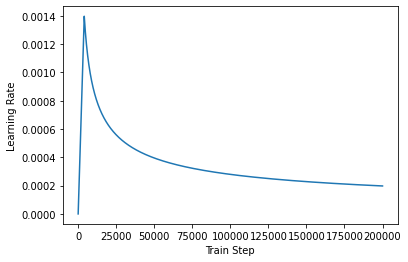

In [42]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")